In [1]:
import os
import numpy as np
os.chdir('/import/home2/yhchenmath/Code/ucs/')
# No warning
import warnings
import tifffile
import h5py
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')
from downstream.utils import read_json_to_namespace

config = read_json_to_namespace("./downstream/config/xenium_breast_cancer.json")

In [2]:
import pandas as pd
df_dict = {}
for method in config.segmentation_results.keys():
    if os.path.exists(os.path.join(config.output_dir, f"{method}_cell_feature.csv")):
        df_dict[method] = pd.read_csv(os.path.join(config.output_dir, f"{method}_cell_feature.csv"), index_col=0)
    else:
        print(f"{method} csv not found")

# gene names txt
with open(config.gene_names, 'r') as f:
    gene_names = f.readlines()
gene_names = [gene_name.strip() for gene_name in gene_names]
gene_num = len(gene_names)

for method in df_dict.keys():
    df_dict[method].dropna(inplace=True)
    df_dict[method]['total'] = df_dict[method].iloc[:, :gene_num].sum(axis=1)
    df_dict[method]['gene_count'] = (df_dict[method].iloc[:, :gene_num] > 0).sum(axis=1)

In [3]:
# Max length of all dataframes
max_len = 0
for df in df_dict.keys():
    if len(df_dict[df]) > max_len:
        max_len = len(df_dict[df])

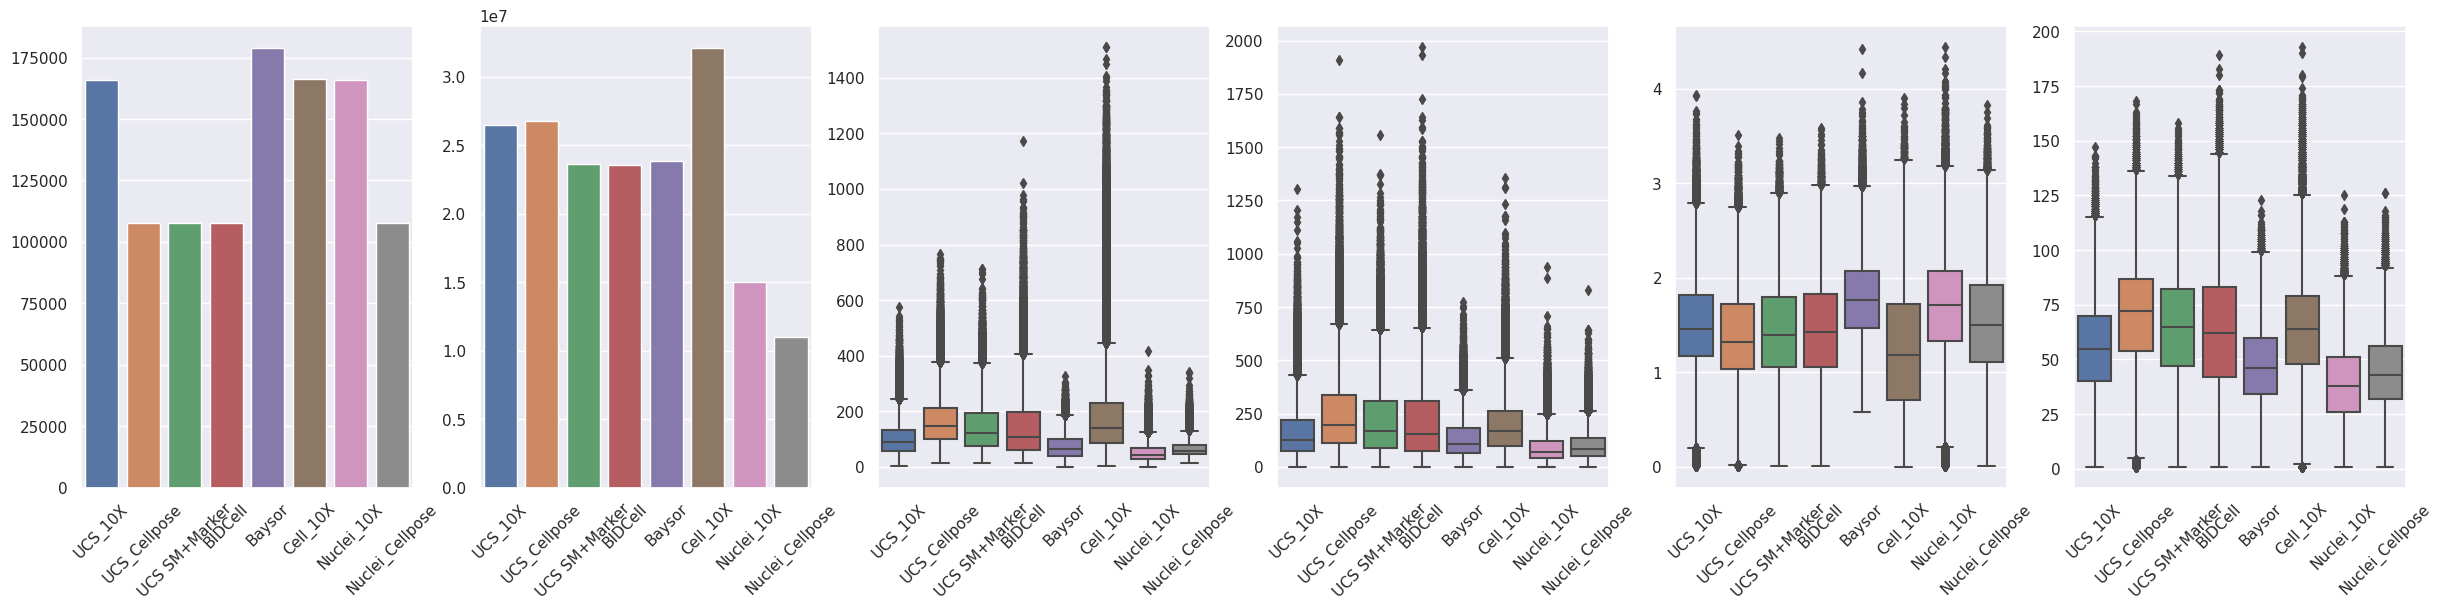

In [4]:
# Basic statistics
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1, 6, figsize=(30, 6))
ax = ax.flatten()

# Rerange the order of the dict
# Total cell number
cell_num = []
for method in df_dict.keys():
    cell_num.append(len(df_dict[method]))
# Plot
sns.barplot(x=list(df_dict.keys()), y=cell_num, ax=ax[0])
#  ax[0].set_title('Cell Number')

# Total Transcripts Assigned
transcripts_assigned = []
for method in df_dict.keys():
    transcripts_assigned.append(df_dict[method]['total'].sum())
sns.barplot(x=list(df_dict.keys()), y=transcripts_assigned, ax=ax[1])
# ax[1].set_title('Transcripts Assigned')

# Box plot cell area
df_area = pd.DataFrame(index=range(max_len))
for method in df_dict.keys():
    total = df_dict[method]['area']
    # Reindex from 0
    total.index = range(len(total))
    df_area[method] = total
sns.boxplot(data=df_area, ax=ax[2])
# ax[2].set_title('Cell Area')

# Box plot number of total transcripts per cell
df_total = pd.DataFrame(index=range(max_len))
for method in df_dict.keys():
    total = df_dict[method]['total']
    # Reindex from 0
    total.index = range(len(total))
    df_total[method] = total
sns.boxplot(data=df_total, ax=ax[3])
# ax[3].set_title('Total Transcripts Cell')

# Box plot of total/area
df_total_area = pd.DataFrame(index=range(max_len))
for df in df_dict.keys():
    total_area = df_dict[df]['total'] / df_dict[df]['area']
    total_area.index = range(len(total_area))
    df_total_area[df] = total_area
# Axis limit
sns.boxplot(data=df_total_area, ax=ax[4])
# ax[4].set_title('TranscriptsPerCellPixel')

# Box plot number of genes per cell
df_gene = pd.DataFrame(index=range(max_len))
for df in df_dict.keys():
    gene_count = df_dict[df]['gene_count']
    gene_count.index = range(len(gene_count))
    df_gene[df] = gene_count
sns.boxplot(data=df_gene, ax=ax[5])
# ax[5].set_title('Total Genes Cell')

# Roatate x lim
for i in range(6):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
plt.show()